In [1]:
import tensorflow as tf
import cv2 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from kerastuner import RandomSearch
from torch.utils.data import DataLoader, TensorDataset,Subset, random_split#changed
import torchvision.transforms as transforms#changed
from torchvision.datasets import ImageFolder#changed
from sklearn.model_selection import KFold #changed
from torchvision import transforms
import torch.nn.functional as F
import random
import time

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# Get time consumption
def getTime(func):
    def _wrapper(*args, **kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        end = time.time()
        print(f"Total time consumption:{end-start:.3f}s")
        return res
    return _wrapper

In [3]:
# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'train_data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('train_data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('train_data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


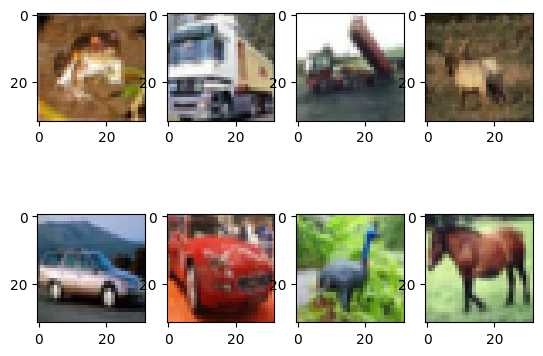

In [4]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [7]:
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
aug_df = train_datagen.flow(imgs,noisy_labels,batch_size = 50000,seed=1,shuffle=False)
imgs1,noisy = aug_df.next()
# Split the dataset into training and testing sets
random.seed(2023)
X_train, X_val,y_train, y_val = train_test_split(imgs1,noisy,test_size=0.2)
X_train, X_val= X_train.astype('float32'), X_val.astype('float32')

Epoch 1/5
250/250 [==============================] - 7s 27ms/step - loss: 2.2794 - accuracy: 0.1430 - val_loss: 2.2699 - val_accuracy: 0.1559
Epoch 2/5
250/250 [==============================] - 7s 27ms/step - loss: 2.2502 - accuracy: 0.1833 - val_loss: 2.2501 - val_accuracy: 0.1876
Epoch 3/5
250/250 [==============================] - 7s 27ms/step - loss: 2.2333 - accuracy: 0.1963 - val_loss: 2.2450 - val_accuracy: 0.1902
Epoch 4/5
250/250 [==============================] - 7s 27ms/step - loss: 2.2197 - accuracy: 0.2074 - val_loss: 2.2455 - val_accuracy: 0.1899
Epoch 5/5
250/250 [==============================] - 7s 28ms/step - loss: 2.2065 - accuracy: 0.2159 - val_loss: 2.2420 - val_accuracy: 0.1934
test loss: 2.243729591369629
test accuracy: 0.20090000331401825


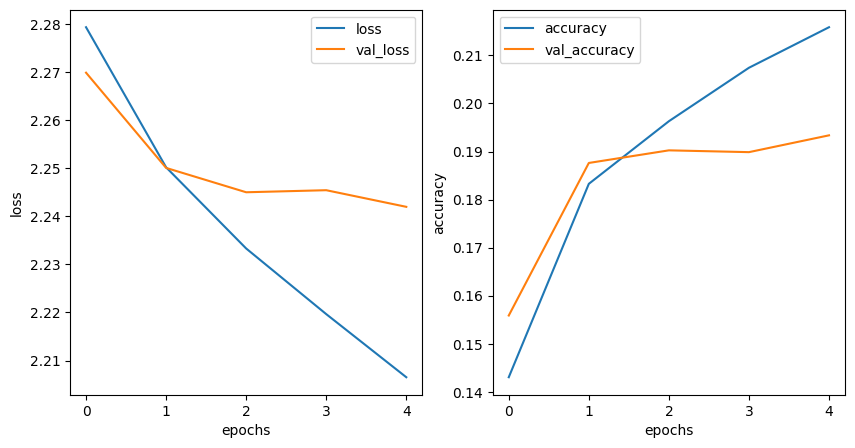

In [9]:
# Create a Sequential model using keras. This is a baseline cnn to compare with the tuner result.
cnn1 = keras.Sequential()
# Add a Conv2D layer with 6 filters of size 3x3, using ReLU activation function, with an input shape of 32x32x3
cnn1.add(layers.Conv2D(6, kernel_size=(3,3), activation='relu',input_shape = (32,32,3)))
# Add a MaxPooling2D layer with pool size of 2x2
cnn1.add(layers.MaxPooling2D(pool_size=(2,2)))
# Add another Conv2D layer with 120 filters of size 5x5, using ReLU activation function
cnn1.add(layers.Conv2D(120,kernel_size=(5,5),activation='relu'))
# Flatten the output from the previous layer
cnn1.add(layers.Flatten())
# Add a Dense layer with 32 units and ReLU activation function
cnn1.add(layers.Dense(32,activation='relu'))
# Add a Dense layer with 10 units and softmax activation function
cnn1.add(layers.Dense(10,activation='softmax'))

# Compile the model with Adam optimizer, categorical_crossentropy loss function, and accuracy as the evaluation metric
cnn1.compile('adam','sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model using the fit() method, with batch size of 128, 40 epochs, and 20% of the data as validation set
history = cnn1.fit(X_train,y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)
hist = pd.DataFrame(history.history)
# Extract the loss, validation loss, accuracy, and validation accuracy from the history
loss = hist['loss']
val_loss = hist['val_loss']
accuracy = hist['accuracy']
val_accuracy = hist['val_accuracy']

# Plot the loss and validation loss over epochs in the first subplot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(hist.index,loss,label='loss')
ax1.plot(hist.index,val_loss,label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

# Plot the accuracy and validation accuracy over epochs in the second subplot
ax2.plot(hist.index,accuracy,label='accuracy')
ax2.plot(hist.index,val_accuracy,label='val_accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()

# Evaluate the model on the validation set and print the test loss and test accuracy
scores = cnn1.evaluate(X_val,y_val,verbose=0)
print('test loss:',scores[0])
print('test accuracy:',scores[1])

In [10]:
#Here we define a tuner which allows search in a set parameter space and return the model at specific epoch with highest val accuracy
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=8, max_value=16, step=4),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(32,32,3)),
    keras.layers.MaxPooling2D(
        pool_size=hp.Choice('maxpool_1_size', values = [2]),
    ),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=128, max_value=256, step=64),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    keras.layers.MaxPooling2D(
        pool_size=hp.Choice('maxpool_1_size', values = [2]),
    ),
    keras.layers.Dropout(0.3),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=256, step=64),
        activation='relu'
    ),
    keras.layers.Dropout(0.3),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5,
                    overwrite=True)
tuner.search(X_train,y_train,epochs=5,validation_split = 0.2)

Trial 5 Complete [00h 01m 32s]
val_accuracy: 0.19562500715255737

Best val_accuracy So Far: 0.20937499403953552
Total elapsed time: 00h 10m 14s
INFO:tensorflow:Oracle triggered exit


In [11]:
model1=tuner.get_best_models(num_models=1)[0]
#summary of best model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       37120     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [12]:
model1.evaluate(X_val,y_val,verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 2.2302 - accuracy: 0.2046


[2.2301862239837646, 0.2046000063419342]

In [13]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here... 

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_reshape = np.expand_dims(image/225,0)
    pred = model1.predict(img_reshape,verbose=0)
    return np.argmax(pred,1)[0]

### 2.3. Model II

In [14]:
# split data
clean_x = imgs1[0:10000]
noisy_x = imgs1[10000:]
noisy_labels_4w =  noisy[10000:]

# split the clean dataset into train and test
random.seed(2023)
#changed
x_train_clean, x_test, y_train_clean, y_test = train_test_split(clean_x, clean_labels, test_size=0.2)

# combine the clean train dataset with noisy dataset
x_train_combined = np.concatenate((x_train_clean, noisy_x))
#y_train_combined = np.concatenate((y_train_clean, noisy_labels_4w))

# normalization
#x_test = x_test/255.0
#x_train_combined = x_train_combined/255.0
#x_train_clean = x_train_clean/255.0

In [15]:
# CNN
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x
    

In [16]:
# train model once and return loss

@getTime
def train_model(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0 # big diff between 0.01 and 0.0
    for x, label in train_loader:
        x, label = x.to(device), label.to(device)
        optimizer.zero_grad()
        fitted = model(x)
        loss = loss_function(fitted, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    # update learning rate 
    lr = 0.1 * (0.1 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    #update batch normalization layers
    model.eval()
    with torch.no_grad():
        for input_data, ground_truth_labels in train_loader:
            input_data = input_data.to(device)
            output = model(input_data)
            
    return running_loss / len(train_loader)

#calculate loss function
def get_loss(model,loader):
    running_loss = 0.0
    for x, label in loader:
        x, label = x.to(device), label.to(device)
        fitted = model(x)
        loss = loss_function(fitted, label)
        running_loss += loss.item()
    return running_loss / len(loader)
    
# validation 
def validate_model(model, loader, device,sample_size):
    model.eval()
    num_correct_predictions = 0
    num_total_samples = 0

    with torch.no_grad(): # disable the gradient calculation
        for x, labels in loader:
            x, labels = x.to(device), labels.to(device)
            fitted = model(x)
            max_, predicted = torch.max(fitted.data, 1)
            num_correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * num_correct_predictions /sample_size
    return accuracy

In [17]:
# prepare the dataset and data loaders
# 'permute()' change the dimensions from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width).
y_clean_tensor = torch.tensor(clean_labels).long()
x_clean_tensor = torch.tensor(clean_x).float().permute(0, 3, 1, 2)

dataset = TensorDataset(x_clean_tensor, y_clean_tensor)

# set up training parameters, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k_folds = 4
loss_function = nn.CrossEntropyLoss()
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
max_acc = []
fold_train_losses=[]
fold_test_losses=[]
fold_train_accuracys=[]
fold_test_accuracys=[]
fold_models=[]

#changed
#k-fold cross-validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}/{k_folds}")
    
    # Create data loaders for the current fold
    train_loader = DataLoader(Subset(dataset,train_ids), batch_size=64, shuffle=True)
    test_loader = DataLoader(Subset(dataset,val_ids), batch_size=64, shuffle=False)
    
    # Initialize the model, optimizer, and scheduler
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    #Train the model
    train_losses=[]
    test_losses=[]
    train_accuracys=[]
    test_accuracys=[]
    models=[]
    num_epochs = 15
    for epoch in range(num_epochs):
        
        models.append(model)
        
        train_loss = train_model(model, train_loader, loss_function, optimizer, device)
        train_losses.append(train_loss)
        train_acc=validate_model(model, train_loader,device,len(Subset(dataset,train_ids)))
        train_accuracys.append(train_acc)
        
        test_loss=get_loss(model,test_loader)
        test_losses.append(test_loss)
        test_acc=validate_model(model,test_loader,device,len(Subset(dataset,val_ids)))
        test_accuracys.append(test_acc)
    
    del model, optimizer
    #get max acc for each fold
    max_acc.append(np.max(test_accuracys))
    fold_test_accuracys.append(test_accuracys)
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)
    fold_train_accuracys.append(train_accuracys)
    fold_models.append(models)
    
#find best fold
best_fold = np.argmax(max_acc)
best_fold_test_accuracys = fold_test_accuracys[best_fold]
best_fold_test_losses = fold_test_losses[best_fold]
best_fold_train_accuracys = fold_train_accuracys[best_fold]
best_fold_train_losses = fold_train_losses[best_fold]
best_fold_models = fold_models[best_fold]

Fold 1/4
Total time consumption:7.924s
Total time consumption:0.727s
Total time consumption:0.659s
Total time consumption:0.705s
Total time consumption:0.738s
Total time consumption:0.685s
Total time consumption:0.749s
Total time consumption:0.724s
Total time consumption:0.811s
Total time consumption:0.741s
Total time consumption:0.658s
Total time consumption:0.661s
Total time consumption:0.655s
Total time consumption:0.658s
Total time consumption:0.657s
Fold 2/4
Total time consumption:0.648s
Total time consumption:0.660s
Total time consumption:0.664s
Total time consumption:0.827s
Total time consumption:0.657s
Total time consumption:0.678s
Total time consumption:0.685s
Total time consumption:0.669s
Total time consumption:0.779s
Total time consumption:0.697s
Total time consumption:0.697s
Total time consumption:0.671s
Total time consumption:0.700s
Total time consumption:0.732s
Total time consumption:0.662s
Fold 3/4
Total time consumption:0.706s
Total time consumption:0.674s
Total time co

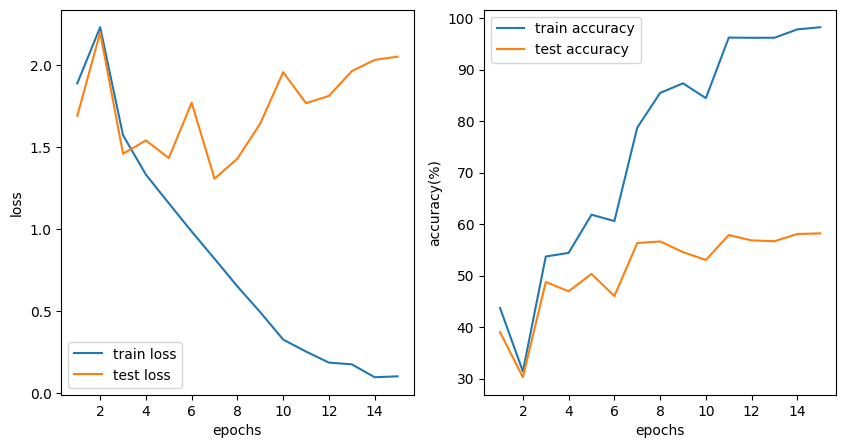

In [18]:
#Visualization to determine the optimal number of epoches
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
axes_x=list(range(1,num_epochs+1 ))
ax1.plot(axes_x,best_fold_train_losses,label='train loss')
ax1.plot(axes_x,best_fold_test_losses,label='test loss')

ax2.plot(axes_x,best_fold_train_accuracys,label='train accuracy')
ax2.plot(axes_x,best_fold_test_accuracys,label='test accuracy')

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy(%)')
ax2.legend()

In [19]:
#best epoch
best_epoch = np.argmax(best_fold_test_accuracys)
model=models[best_epoch]    # image change, where is the randomness comes from
print(f'Accuracy on test data: {validate_model(model,test_loader,device,len(y_test))}%')

Accuracy on test data: 72.5%


In [20]:
#Function of implementing the cleaning model
def clean_label(image):
    # Convert the input images
    noisy_x_tensor = torch.tensor(image).float().permute(0, 3, 1, 2)
    noisy_dataset = TensorDataset(noisy_x_tensor)
    noisy_loader = DataLoader(noisy_dataset, batch_size=64, shuffle=False)

    # evaluation mode
    model.eval()
    predicted_outputs = torch.tensor([], dtype=torch.long)

    with torch.no_grad():
        for x in noisy_loader:
            x = x[0].to(device)
            fitted = model(x)
            # Get the index of the predicted class for each input image in the batch
            max_, predicted_classes = torch.max(fitted.data, 1)
            predicted_outputs = torch.cat((predicted_outputs, predicted_classes.cpu()), dim=0)
            
    return np.array(predicted_outputs)

In [21]:
#Clean the 40000 noisy labels
cleaned_labels=clean_label(imgs1[10000:])

# Concat both dataset and split into train & test data
labels=np.concatenate((clean_labels, cleaned_labels))
random.seed(2023)
X_train, X_val,y_train, y_val = train_test_split(imgs1,labels,test_size=0.2)
X_train, X_val= X_train.astype('float32'), X_val.astype('float32')


In [22]:
#Here we took the parameter of model 1 out and build a new model.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
modelx = build_model(best_hps[0])
modelx.fit(X_train,y_train,epochs=15,validation_data = (X_val,y_val),verbose=1)

Epoch 1/15
1250/1250 [==============================] - 35s 28ms/step - loss: 1.5858 - accuracy: 0.4265 - val_loss: 1.3072 - val_accuracy: 0.5464
Epoch 2/15
1250/1250 [==============================] - 35s 28ms/step - loss: 1.3334 - accuracy: 0.5277 - val_loss: 1.1858 - val_accuracy: 0.5850
Epoch 3/15
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2351 - accuracy: 0.5617 - val_loss: 1.1148 - val_accuracy: 0.6045
Epoch 4/15
1250/1250 [==============================] - 36s 29ms/step - loss: 1.1730 - accuracy: 0.5835 - val_loss: 1.1131 - val_accuracy: 0.6151
Epoch 5/15
1250/1250 [==============================] - 36s 29ms/step - loss: 1.1299 - accuracy: 0.5990 - val_loss: 1.0668 - val_accuracy: 0.6312
Epoch 6/15
1250/1250 [==============================] - 35s 28ms/step - loss: 1.0955 - accuracy: 0.6107 - val_loss: 1.0462 - val_accuracy: 0.6373
Epoch 7/15
1250/1250 [==============================] - 35s 28ms/step - loss: 1.0687 - accuracy: 0.6194 - val_loss: 1.0590 -

In [23]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    img_reshape = np.expand_dims(image/225,0)
    pred = modelx.predict(img_reshape,verbose=0)
    return np.argmax(pred,1)[0]

# 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [24]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [26]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

FileNotFoundError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.